# Skin lesion Segmentation using ISIC dataset and U-Net architecture

In [2]:
import cv2
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

#import albumentations as A

import os
import matplotlib.pyplot as plt

from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torchvision import transforms
#from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
from PIL import Image
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:


# Constants
TRAIN_IMG_PATH1 = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input'
TRAIN_MASK_PATH1 = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth'

# List all image files and mask files
train_image_files = [image_file for image_file in os.listdir(TRAIN_IMG_PATH1) if image_file.endswith('.jpg')]
train_mask_files = [mask_file for mask_file in os.listdir(TRAIN_MASK_PATH1) if mask_file.endswith('_segmentation.png')]

# Shuffle both lists in the same way
random.seed(42)  # for reproducibility
random.shuffle(train_image_files)
random.shuffle(train_mask_files)






In [10]:
import os
import random

# Constants
TRAIN_IMG_PATH1 = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input'
TRAIN_MASK_PATH1 = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth'

# load the image and mask filepaths in a sorted manner
imagePaths = sorted(os.path.join(TRAIN_IMG_PATH1, image_file) for image_file in os.listdir(TRAIN_IMG_PATH1) if image_file.endswith('.jpg'))
maskPaths = sorted(os.path.join(TRAIN_MASK_PATH1, mask_file) for mask_file in os.listdir(TRAIN_MASK_PATH1) if mask_file.endswith('_segmentation.png'))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
test_size=0.2, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]


In [5]:
len(imagePaths)

2594

In [6]:
len(trainImages)

2075

In [7]:
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
os.mkdir(BASE_OUTPUT)
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_model_1.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [8]:
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


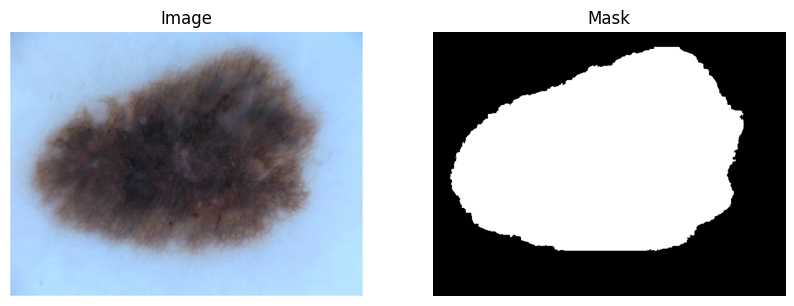

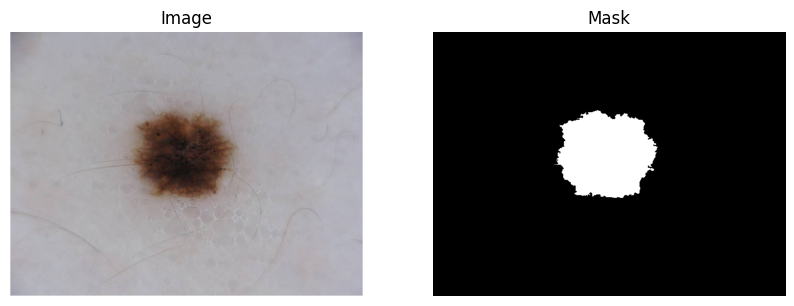

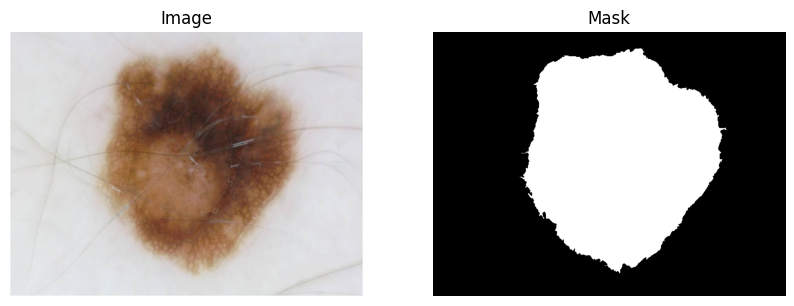

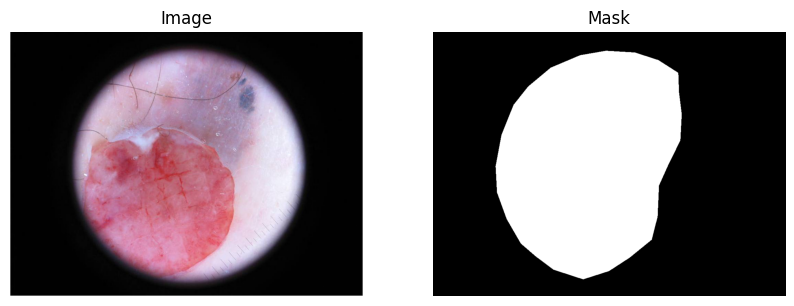

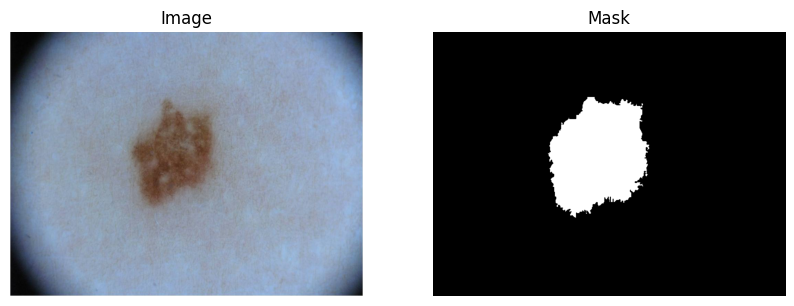

In [11]:
selected_image_files = imagePaths[:5]
selected_mask_files = maskPaths[:5]

# Display the selected images and masks
for img_file, mask_file in zip(selected_image_files, selected_mask_files):
    image_path = img_file#os.path.join(TRAIN_IMG_PATH1, img_file)
    mask_path = mask_file#os.path.join(TRAIN_MASK_PATH1, mask_file)
    
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    
    plt.show()



UNET

In [12]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Contracting path (encoder)
        self.conv1 = nn.Conv2d(self.n_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expansive path (decoder)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        # Contracting path (encoder)
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(self.pool(x1)))
        x3 = F.relu(self.conv3(self.pool(x2)))
        x4 = F.relu(self.conv4(self.pool(x3)))
        x5 = F.relu(self.conv5(self.pool(x4)))

        # Expansive path (decoder)
        x6 = F.relu(self.upconv1(x5))
        x6 = torch.cat([x4, x6], dim=1)
        x6 = F.relu(self.conv6(x6))
        x7 = F.relu(self.upconv2(x6))
        x7 = torch.cat([x3, x7], dim=1)
        x7 = F.relu(self.conv7(x7))
        x8 = F.relu(self.upconv3(x7))
        x8 = torch.cat([x2, x8], dim=1)
        x8 = F.relu(self.conv8(x8))
        x9 = F.relu(self.upconv4(x8))
        x9 = torch.cat([x1, x9], dim=1)
        x9 = F.relu(self.conv9(x9))
        x10 = self.conv10(x9)

        return x10
    

Linknet

In [ ]:
import torch
import torch.nn as nn

class LinkNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinkNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class LinkNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LinkNet, self).__init__()
        
        # Initial convolution
        self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.initial_bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # Encoder
        self.encoder1 = LinkNetBlock(64, 64)
        self.encoder2 = LinkNetBlock(64, 128)
        self.encoder3 = LinkNetBlock(128, 256)
        self.encoder4 = LinkNetBlock(256, 512)
        
        # Decoder
        self.decoder4 = LinkNetBlock(512, 256)
        self.decoder3 = LinkNetBlock(256, 128)
        self.decoder2 = LinkNetBlock(128, 64)
        self.decoder1 = LinkNetBlock(64, 64)
        
        # Final classification layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.relu(x)
        
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        
        dec4 = self.decoder4(enc4)
        dec3 = self.decoder3(dec4 + enc3)
        dec2 = self.decoder2(dec3 + enc2)
        dec1 = self.decoder1(dec2 + enc1)
        
        out = self.final_conv(dec1)
        return out

# Instantiate the LinkNet model
in_channels = 3  # Number of input channels (e.g., RGB images)
num_classes = 1  # Number of classes in the segmentation task
model = LinkNet(in_channels, num_classes)

# Print the model architecture
#print(model)


ConvMixer 

In [ ]:
import torch
import torch.nn as nn

class ConvMixerBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, expansion_factor):
        super(ConvMixerBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels * expansion_factor, kernel_size=1)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv1d(in_channels * expansion_factor, in_channels, kernel_size=kernel_size, padding=kernel_size//2)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.gelu(out)
        out = self.conv2(out)
        return out

class ConvMixer(nn.Module):
    def __init__(self, in_channels, num_classes, num_blocks, expansion_factor, kernel_size):
        super(ConvMixer, self).__init__()
        
        self.stem = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=7, stride=2, padding=3)
        self.blocks = nn.ModuleList([
            ConvMixerBlock(in_channels * expansion_factor, kernel_size, expansion_factor)
            for _ in range(num_blocks)
        ])
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(in_channels * expansion_factor, num_classes)
    
    def forward(self, x):
        x = self.stem(x)
        for block in self.blocks:
            x = block(x)
        x = self.global_avg_pool(x).squeeze(-1).squeeze(-1)
        out = self.classifier(x)
        return out

# Instantiate the ConvMixer model
in_channels = 3  # Number of input channels (e.g., RGB images)
num_classes = 10  # Number of classes in the classification task
num_blocks = 8  # Number of ConvMixer blocks
expansion_factor = 4  # Expansion factor for each block
kernel_size = 9  # Kernel size for each block
model = ConvMixer(in_channels, num_classes, num_blocks, expansion_factor, kernel_size)

# Print the model architecture
print(model)


<font size=+2><b>2.Preparing Data</b> <br></font>

<font size=+1><b>2.1 Creating Custom Dataset</b> <br> </font>

In [13]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

import cv2


# Constants

SIZE = 128
BATCH_SIZE = 4
NUM_WORKERS = 4
#PIN_MEMORY = True
NUM_EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [30]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None): #do_enhancement=False
        self.images_path = images_path
        self.masks_path = masks_path
        self.transforms = transform
        #self.do_enhancement = do_enhancement

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        
        image_path = self.images_path[idx]
        image = cv2.imread(image_path)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
        
        
        mask = cv2.imread(self.masks_path[idx], 0)
        
       # if self.do_enhancement:
          #  img = self.enhance_image(img)
        
        
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            img = self.transforms(img)
            mask = self.transforms(mask)
        
        return (img, mask)

    
    def enhance_image(self, image):
       # Apply denoising filters (e.g., bilateral filter)
       denoised_img = cv2.bilateralFilter(np.array(image), d=9, sigmaColor=75, sigmaSpace=75)

        Apply super-resolution using interpolation
        enhanced_img = cv2.resize(denoised_img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
        return Image.fromarray(enhanced_img)


In [17]:
from torchvision import transforms

In [18]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ToTensor()
])

In [31]:
trainDS = ISICDataset(images_path=trainImages, masks_path=trainMasks,
    transform=transform)
testDS = ISICDataset(images_path=testImages, masks_path=testMasks,
    transform=transform)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")


[INFO] found 2075 examples in the training set...
[INFO] found 519 examples in the test set...


In [35]:
os.cpu_count()

4

In [36]:
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count())

In [37]:
# Initialize the U-Net model and optimizer
model = UNet(n_channels=3, n_classes=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [38]:

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = criterion(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalTestLoss += criterion(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

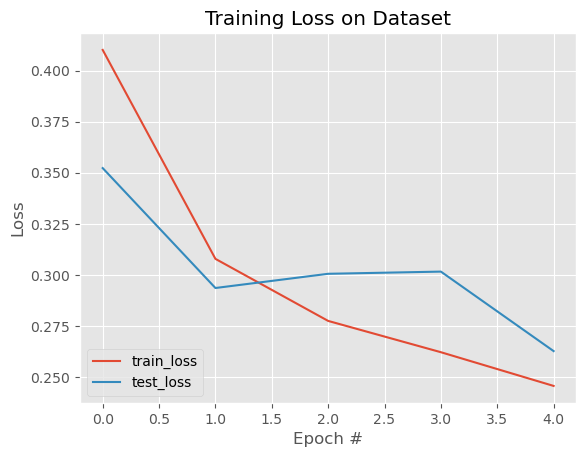

In [41]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(model, MODEL_PATH)

We will now plot some predictions

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [43]:
THRESHOLD = 0.5

In [53]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (SIZE, SIZE))
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1]
        filename_ = filename.split(".")[0]
        groundTruthPath = os.path.join(TRAIN_MASK_PATH1,
            filename_ +"_segmentation.png")
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, 0)
        gtMask = cv2.resize(gtMask, (SIZE,
            SIZE))
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > THRESHOLD) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)

In [54]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

[INFO] loading up test image paths...


In [47]:
imagePaths

array(['/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0000379.jpg',
       '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0000501.jpg',
       '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0013946.jpg',
       '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0012721.jpg',
       '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0013599.jpg',
       '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0012118.jpg',
       '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0013908.jpg',
       '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0015175.jpg',
       '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC201

[INFO] load up model...


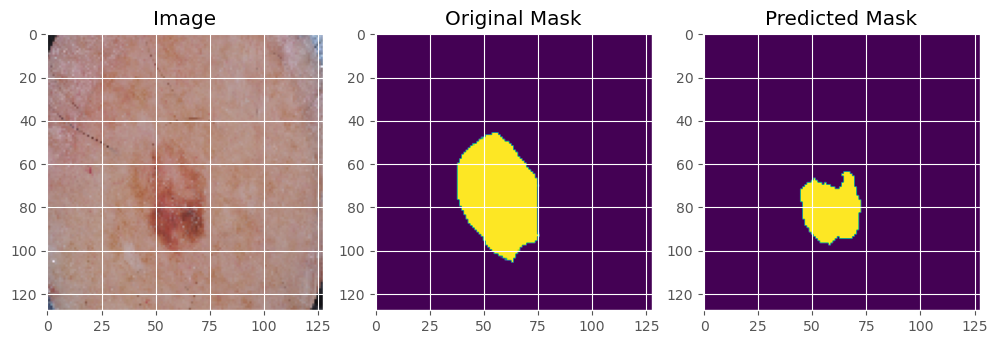

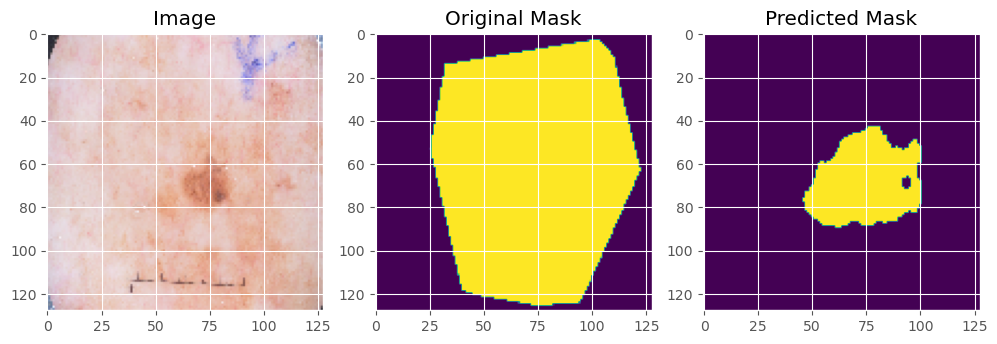

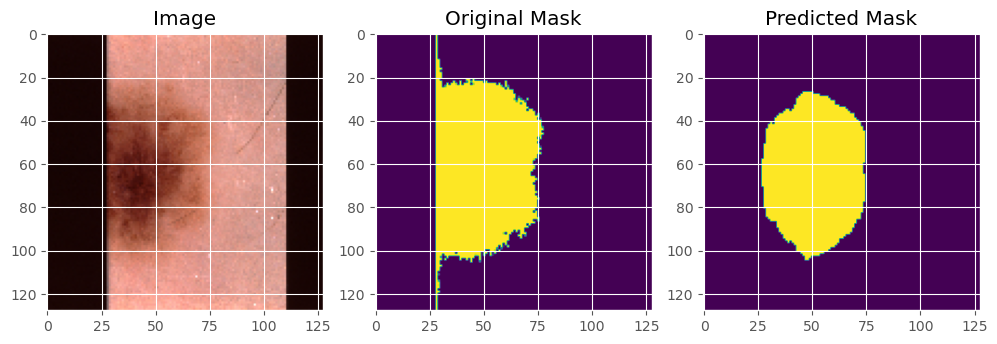

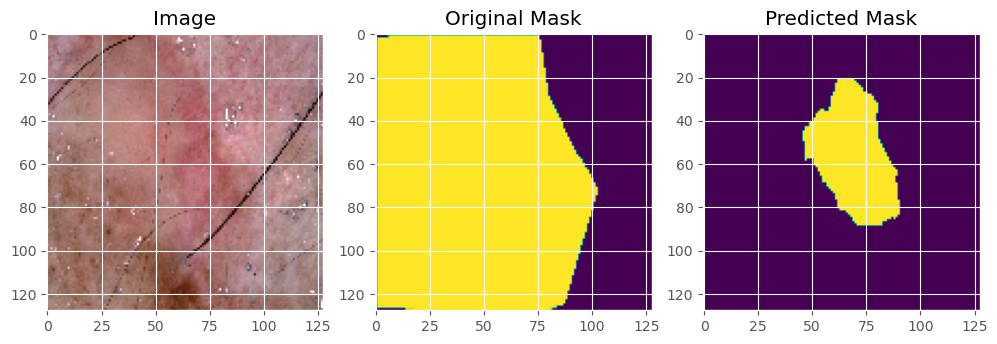

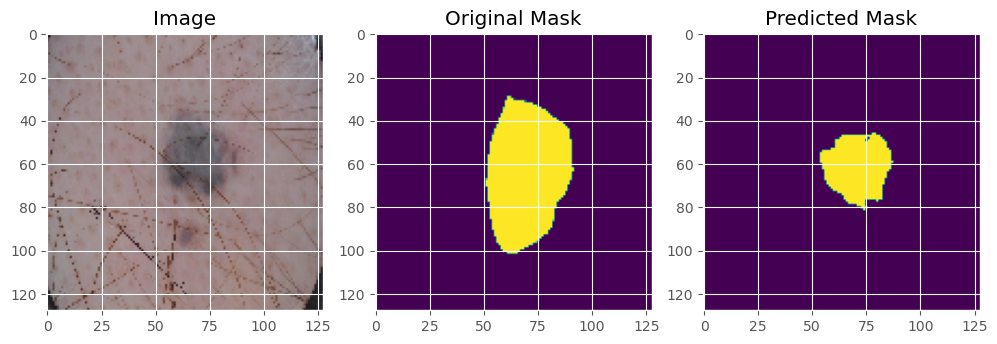

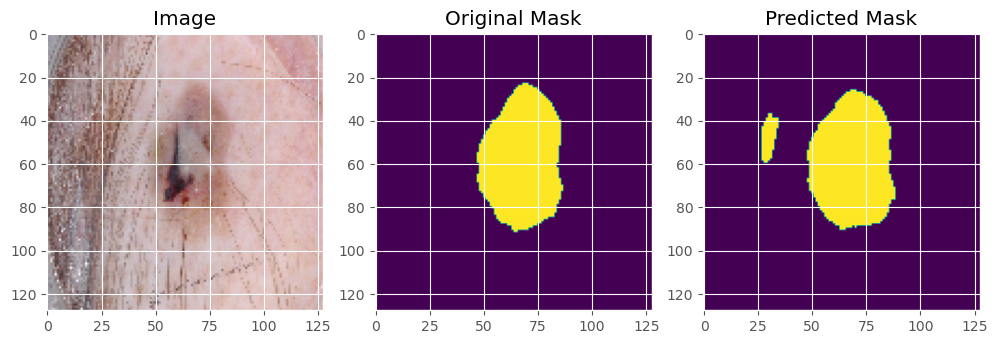

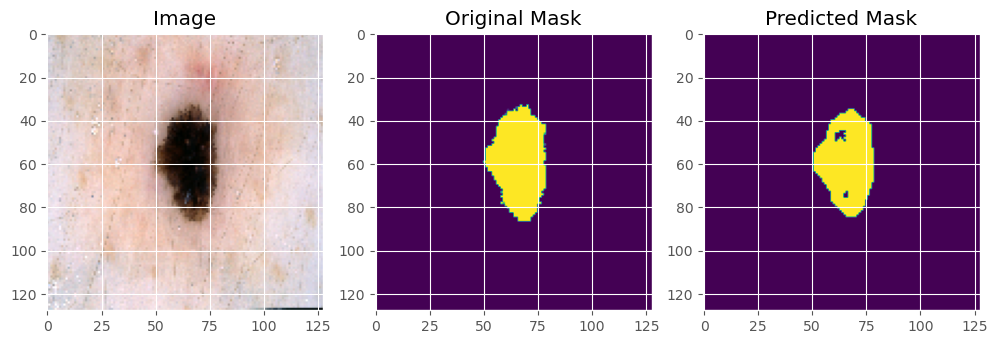

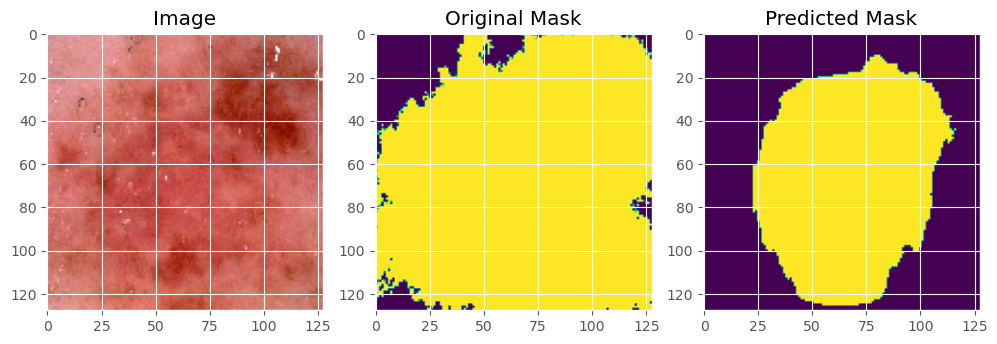

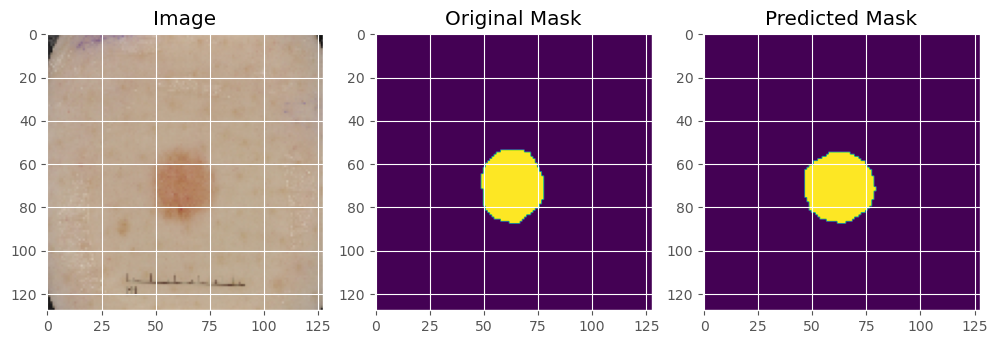

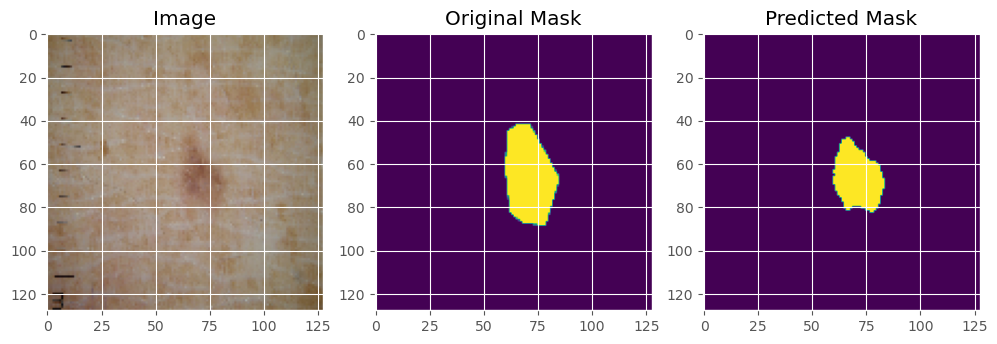

In [55]:

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)

In [ ]:
def calculate_metrics(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum()
    union = torch.logical_or(pred_mask, true_mask).sum()

    dice = (2.0 * intersection) / (pred_mask.sum() + true_mask.sum())
    jaccard = intersection / union
    iou = intersection / (pred_mask.sum() + true_mask.sum() - intersection)
    
    epsilon = 1e-7  # Small constant to avoid division by zero
    precision = intersection / (pred_mask.sum() + epsilon)
    recall = intersection / (true_mask.sum() + epsilon)
    f1 = (2 * precision * recall) / (precision + recall + epsilon)

    return dice, jaccard, iou, f1

# Example usage

dice, jaccard, iou, f1 = calculate_metrics(ypred, y)

print("Dice Coefficient:", dice.item())
print("Jaccard Index:", jaccard.item())
print("IoU:", iou.item())
print("F1 Score:", f1.item())